In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [5]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 데이터 준비

In [6]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.341,0.121,0.245,0.009,0.085,0.154,0.161,0.311,0.358,0.177,...,0.372,0.181,0.322,0.374,0.571,0.453,0.161,0.127,0.259,0.364
2018-05-01 01:00:00,0.337,0.186,0.285,0.010,0.071,0.127,0.179,0.225,0.206,0.178,...,0.245,0.238,0.292,0.382,0.327,0.352,0.172,0.133,0.234,0.286
2018-05-01 02:00:00,0.324,0.214,0.487,0.009,0.061,0.139,0.182,0.221,0.150,0.152,...,0.245,0.250,0.287,0.320,0.359,0.366,0.242,0.219,0.197,0.368
2018-05-01 03:00:00,0.319,0.250,0.300,0.009,0.067,0.132,0.172,0.274,0.142,0.205,...,0.177,0.223,0.329,0.170,0.322,0.267,0.269,0.164,0.229,0.414
2018-05-01 04:00:00,0.235,0.199,0.107,0.009,0.047,0.131,0.153,0.255,0.139,0.169,...,0.129,0.171,0.301,0.168,0.351,0.255,0.170,0.132,0.198,0.318


In [7]:
# 1월치 데이터 파싱
m_15_1 = m_15[m_15.index.month == 1].copy()
m_15_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.008,0.0,0.013,0.009,0.015,0.100,0.059,0.026,0.090,0.066,...,0.068,0.024,0.090,0.097,0.131,0.103,0.115,0.062,0.090,0.172
2019-01-01 00:15:00,0.008,0.0,0.007,0.009,0.016,0.083,0.061,0.059,0.106,0.021,...,0.141,0.049,0.112,0.103,0.094,0.187,0.125,0.076,0.048,0.165
2019-01-01 00:30:00,0.008,0.0,0.007,0.010,0.016,0.077,0.057,0.078,0.098,0.082,...,0.174,0.068,0.094,0.062,0.124,0.165,0.146,0.061,0.085,0.185
2019-01-01 00:45:00,0.009,0.0,0.007,0.009,0.015,0.062,0.063,0.132,0.079,0.074,...,0.151,0.047,0.104,0.056,0.071,0.171,0.098,0.090,0.082,0.130
2019-01-01 01:00:00,0.008,0.0,0.012,0.009,0.016,0.037,0.071,0.111,0.084,0.045,...,0.112,0.065,0.080,0.065,0.104,0.124,0.127,0.089,0.064,0.153


In [8]:
m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


In [9]:
m_60_1[m_60_1.columns[:5]].head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063


# KMeans ++ Algorithm Init Centroids

In [10]:
from sklearn.metrics import euclidean_distances as euc
from src.KMeans import KMeans

kmeans = KMeans(datas=m_60_1.T.values, ver=3)

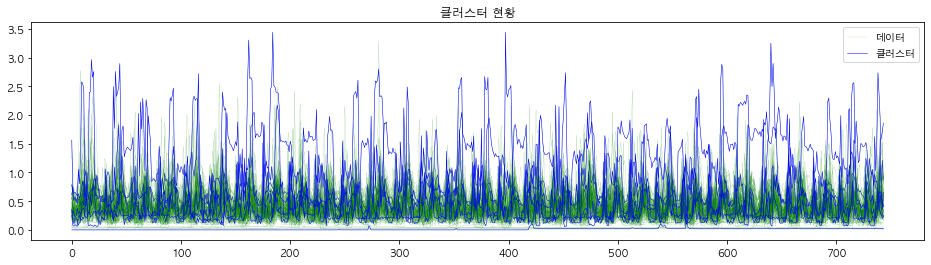

In [11]:
kmeans.init_setting()
kmeans.draw_all_plot()

# KMeans ++ Algorithm Fitting

ECV : 51 %


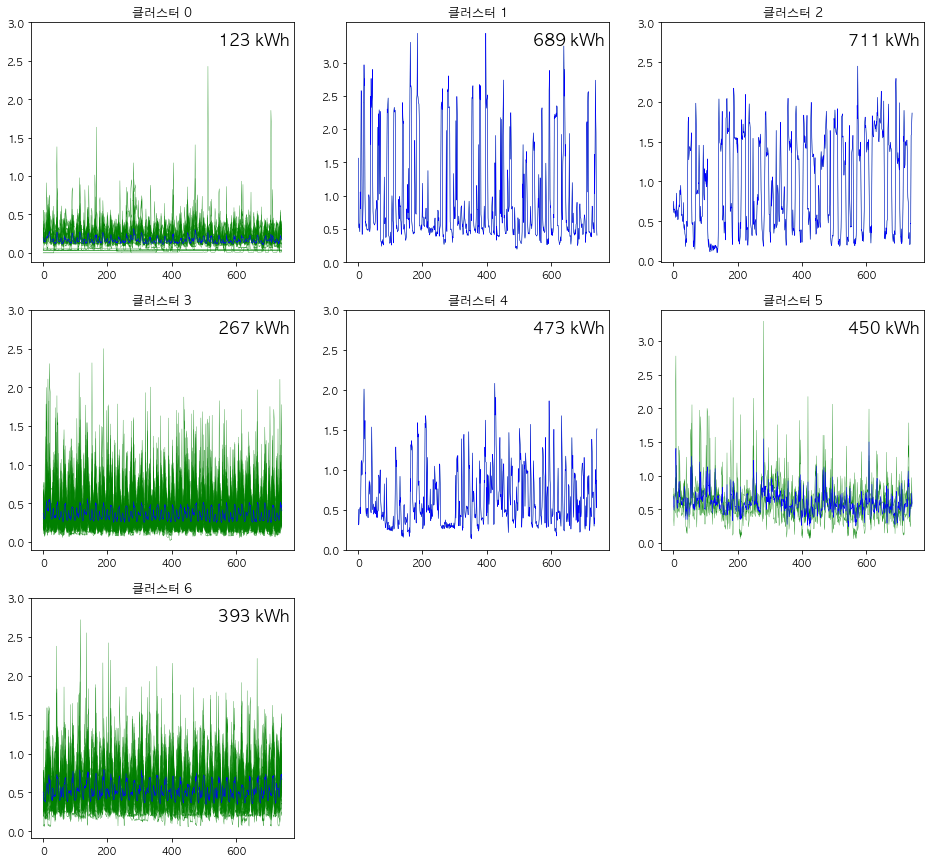

In [12]:
kmeans.fit()
kmeans.draw_plot()

# KMeans ++ Sorting

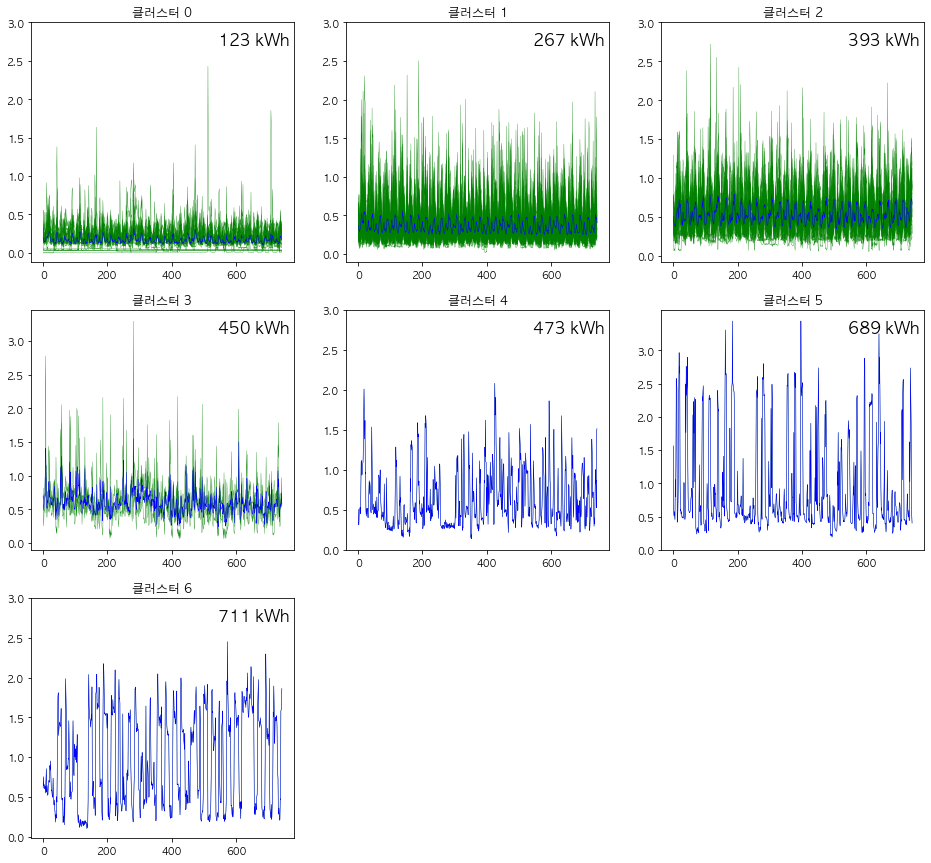

In [13]:
kmeans.sorting()
kmeans.draw_plot()

# 기여도 그룹번호 부여

In [14]:
group_df = ut.make_group_df(m_60_1, kmeans)

group_df

,가구명,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
...,...,...,...
103,아파트1-103-903,273,1
104,아파트1-103-1106,255,1
105,아파트1-103-705,228,1
106,아파트1-103-1505,384,2


# 이상(anomaly) 데이터 탐지 및 제거

In [15]:
anomaly_df = ut.get_anomaly_df(group_df)

anomaly_df

,가구명,usage (kWh),label
27,아파트1-101-402,345,1
20,아파트1-102-403,424,2
52,아파트1-103-1803,420,2
80,아파트1-103-1002,494,2
84,아파트1-102-1402,463,2
86,아파트1-101-1302,455,2
89,아파트1-101-503,422,2
62,아파트1-103-703,498,3


In [21]:
group_df[group_df['label'] == 2]

,가구명,usage (kWh),label
11,아파트1-103-1602,387,2
13,아파트1-103-1502,397,2
20,아파트1-102-403,424,2
23,아파트1-101-1602,350,2
28,아파트1-101-303,376,2
30,아파트1-101-1403,380,2
43,아파트1-102-802,406,2
46,아파트1-103-1805,386,2
51,아파트1-103-1903,405,2
52,아파트1-103-1803,420,2


In [23]:
_1,_2,_3 = ut.adjust_anomaly_df(anomaly=anomaly_df,group_df=group_df, datas=m_60_1)

# new_group_df['label'].value_counts()

In [43]:
_1

,가구명,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
...,...,...,...
103,아파트1-103-903,273,1
104,아파트1-103-1106,255,1
105,아파트1-103-705,228,1
106,아파트1-103-1505,384,2


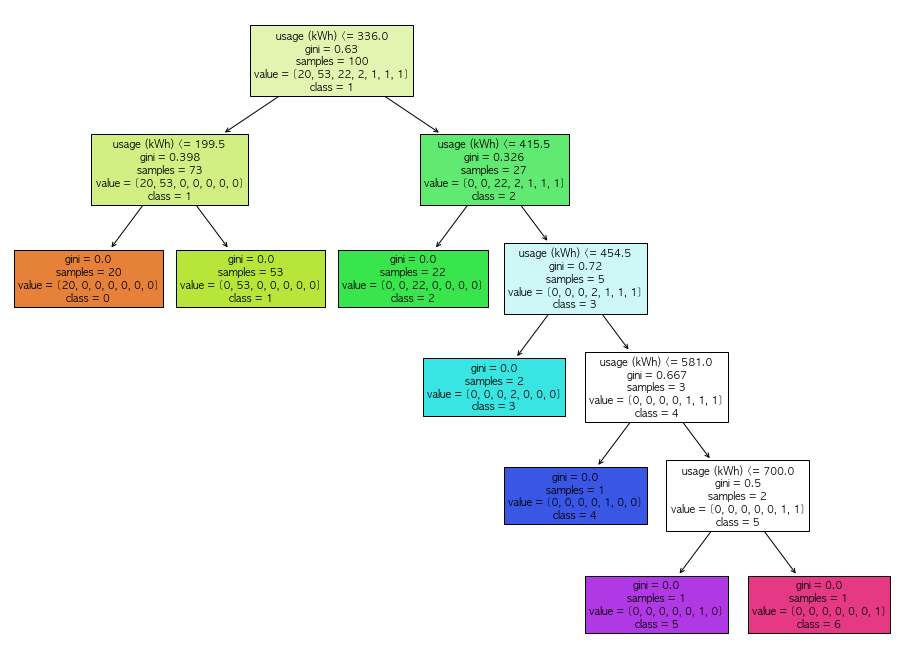

In [41]:
from sklearn.tree import plot_tree


plt.figure(figsize=(16,12))

plot_tree(_2, feature_names=['usage (kWh)'], class_names=["0","1","2","3","4","5","6"], filled=True)

plt.show()

In [42]:
ut.get_anomaly_df(_3)

""


# KMeans 적용

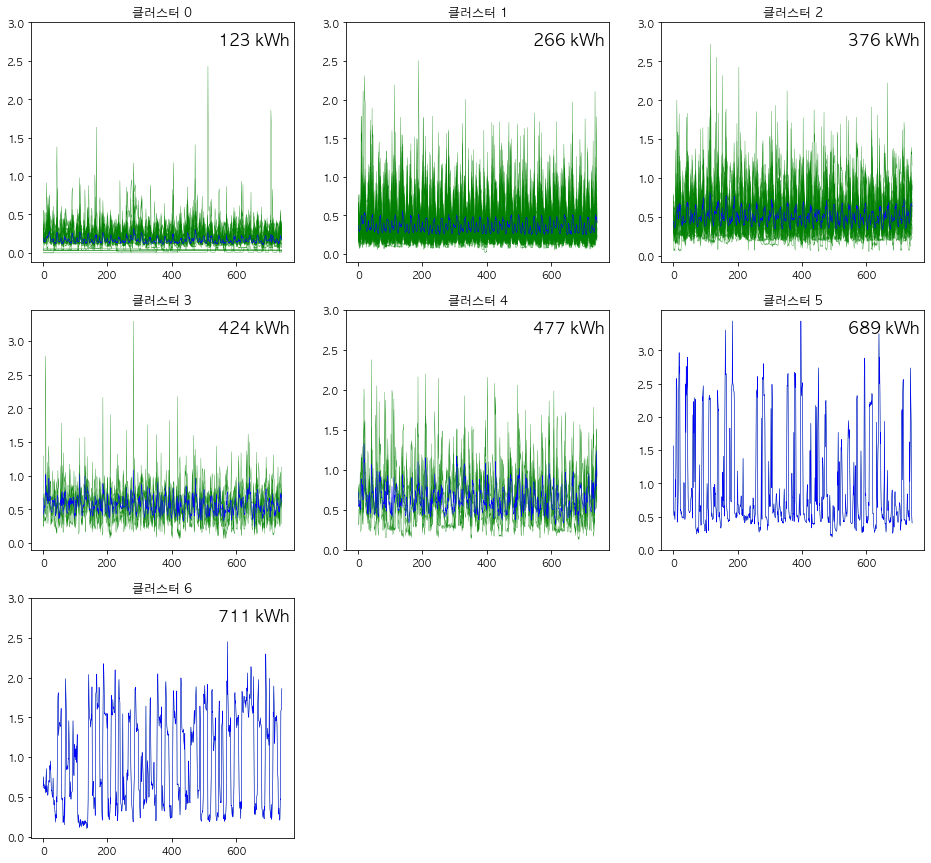

In [45]:
K = _3['label'].value_counts().index.size

kmeans.K = K
kmeans.clusters_ = kmeans.clusters_[:K]
kmeans.labels_ = _3['label'].values

kmeans.next_setting()

kmeans.ecv
kmeans.draw_plot()

In [46]:
kmeans.ecv

0.502761155028924

In [47]:
_3['label'].value_counts()

1    53
2    23
0    20
3     5
4     5
6     1
5     1
Name: label, dtype: int64

In [51]:
kmeans.clusters_.sum()

3065.1275260869565

In [52]:
np.array([123, 267, 393, 450, 473,689, 711]).std()

196.09087855650304

In [53]:
np.array([123, 266, 376, 424, 477, 689, 711]).std()

197.08591310100564

# 기여도 산정

## 그룹화

### label number 부여

In [54]:
_month_df = np.column_stack([m_60_1.columns, m_60_1.sum(axis=0).values.round().astype("int")])
month_df = pd.DataFrame(_month_df, columns=['name', 'usage (kWh)'])

month_df

,name,usage (kWh)
0,아파트1-104-1206,99
1,아파트1-104-303,10
2,아파트1-104-1307,23
3,아파트1-104-1208,40
4,아파트1-104-408,39
...,...,...
103,아파트1-103-903,273
104,아파트1-103-1106,255
105,아파트1-103-705,228
106,아파트1-103-1505,384


In [57]:
labels, clusters = kmeans.labels_, kmeans.clusters_

_cluster_info = np.column_stack([month_df.values, labels])
cluster_info = pd.DataFrame(_cluster_info, columns=['name', 'usage (kWh)','그룹 번호'])

cluster_info.head(10)

,name,usage (kWh),그룹 번호
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
5,아파트1-104-203,197,0
6,아파트1-103-1402,218,1
7,아파트1-103-402,228,1
8,아파트1-103-1201,84,0
9,아파트1-103-801,223,1


In [60]:
_labels = np.unique(labels)
label_cnt = np.array([np.where(labels == _label)[0].size for _label in _labels])

_cont = np.column_stack([_labels, clusters.sum(axis=1).round().astype("int"),label_cnt])
cont = pd.DataFrame(_cont, columns=['그룹 번호', '클러스터 패턴 총 사용량','가구 수'])
cont.set_index("그룹 번호", inplace=True)

cont

,클러스터 패턴 총 사용량,가구 수
그룹 번호,,
0,123,20
1,266,53
2,376,23
3,424,5
4,477,5
5,689,1
6,711,1


## 기여도 산정 1. 그룹의 중간값 ( 클러스터 패턴의 사용량 ) 을 이용한 기여도 산정

In [62]:
cont_1 = cont.copy()

total_median = cont_1['클러스터 패턴 총 사용량'].sum()
cont_1['contribution'] = cont_1['클러스터 패턴 총 사용량'].map(lambda x: x / total_median)

cont_1

,클러스터 패턴 총 사용량,가구 수,contribution
그룹 번호,,,
0,123,20,0.040117
1,266,53,0.086758
2,376,23,0.122635
3,424,5,0.138291
4,477,5,0.155577
5,689,1,0.224723
6,711,1,0.231898


## 기여도 산정 2. 그룹 안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [ ]:
cont_2 = cont.copy()

households_kWh = cluster_info['usage (kWh)'].sum()

cont_2['usage total'] = np.array(
    [cluster_info[cluster_info['그룹 번호'] == _label]['usage (kWh)'].sum() for _label in _labels]
)
cont_2['contribution'] = cont_2['usage total'].map(lambda x: x / households_kWh)

cont_2

# 가격분배

## 단순 가격 분배

In [63]:
_public_bill = round(public_bill / len(cluster_info))
_public_bill

24450

In [64]:
simple_dist_1 = cont_1.copy()

simple_dist_1['공용부 요금'] = simple_dist_1['가구 수'].map(lambda x: x * _public_bill)
simple_dist_1['단순 가격분배'] = (simple_dist_1['공용부 요금'] * simple_dist_1['contribution']).round().astype("int")

simple_dist_1['가구 별 분배 가격'] = simple_dist_1.apply(lambda x: int(x['단순 가격분배'] / x['가구 수']), axis=1)

simple_dist_1

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 요금,단순 가격분배,가구 별 분배 가격
그룹 번호,,,,,,
0,123,20,0.040117,489000,19617,980
1,266,53,0.086758,1295850,112425,2121
2,376,23,0.122635,562350,68964,2998
3,424,5,0.138291,122250,16906,3381
4,477,5,0.155577,122250,19019,3803
5,689,1,0.224723,24450,5494,5494
6,711,1,0.231898,24450,5670,5670


In [65]:
simple_info_1 = cluster_info.copy()

simple_info_1['단순 가격분배'] = simple_info_1['그룹 번호'].map(
        lambda x: int(simple_dist_1.loc[x]['가구 별 분배 가격'])
)

simple_info_1['공용부 요금 나머지'] = round((public_bill - simple_info_1['단순 가격분배'].sum()) / len(cluster_info))
simple_info_1['최종 공용부 요금'] = simple_info_1['단순 가격분배'] + simple_info_1['공용부 요금 나머지']

simple_info_1.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,980,22153,23133
1,아파트1-104-303,10,0,980,22153,23133
2,아파트1-104-1307,23,0,980,22153,23133
3,아파트1-104-1208,40,0,980,22153,23133
4,아파트1-104-408,39,0,980,22153,23133
5,아파트1-104-203,197,0,980,22153,23133
6,아파트1-103-1402,218,1,2121,22153,24274
7,아파트1-103-402,228,1,2121,22153,24274
8,아파트1-103-1201,84,0,980,22153,23133
9,아파트1-103-801,223,1,2121,22153,24274


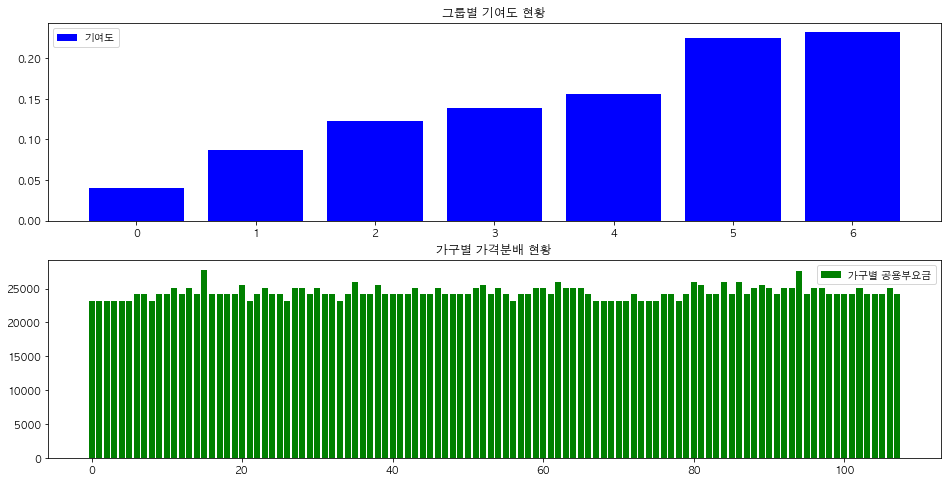

In [66]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(simple_dist_1)), simple_dist_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(simple_info_1)), simple_info_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [67]:
min_h = simple_info_1[simple_info_1['name'] == '아파트1-104-905']
mean_h = simple_info_1[simple_info_1['name'] == '아파트1-102-801']
max_h = simple_info_1[simple_info_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,0,980,22153,23133
44,아파트1-102-801,280,1,2121,22153,24274
15,아파트1-102-903,711,6,5670,22153,27823


## 기여도 요금

In [68]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df[['name', 'usage (kWh)']],
    month=_month
)
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

In [69]:
col_df = cont.copy()

col_df['공용부 기본요금'] = (round(pp.basic / len(month_df)) * col_df['가구 수']).round().astype("int")
col_df['공용부 전력량요금'] = round(pp.elec_rate / len(month_df)) * col_df['가구 수'].round().astype("int")

col_df

,클러스터 패턴 총 사용량,가구 수,공용부 기본요금,공용부 전력량요금
그룹 번호,,,,
0,123,20,85040,331880
1,266,53,225356,879482
2,376,23,97796,381662
3,424,5,21260,82970
4,477,5,21260,82970
5,689,1,4252,16594
6,711,1,4252,16594


In [70]:
dist_1 = pd.concat([cont_1, col_df[col_df.columns[-2:]]], axis=1)

dist_1['기여도 공용부 기본요금'] = (dist_1['공용부 기본요금'] * dist_1['contribution']).round().astype("int")
dist_1['기여도 공용부 전력량요금'] = (dist_1['공용부 전력량요금'] * dist_1['contribution']).round().astype("int")
dist_1['기여도 공용부 요금'] = dist_1['기여도 공용부 기본요금'] + dist_1['기여도 공용부 전력량요금']
dist_1['가구 별 분배 가격'] = (dist_1['기여도 공용부 요금'] / dist_1['가구 수']).round().astype("int")

dist_1

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 기본요금,공용부 전력량요금,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배 가격
그룹 번호,,,,,,,,,
0,123,20,0.040117,85040,331880,3412,13314,16726,836
1,266,53,0.086758,225356,879482,19551,76302,95853,1809
2,376,23,0.122635,97796,381662,11993,46805,58798,2556
3,424,5,0.138291,21260,82970,2940,11474,14414,2883
4,477,5,0.155577,21260,82970,3308,12908,16216,3243
5,689,1,0.224723,4252,16594,956,3729,4685,4685
6,711,1,0.231898,4252,16594,986,3848,4834,4834


In [71]:
dist_info_1 = cluster_info.copy()

dist_info_1['단순 가격분배'] = dist_info_1['그룹 번호'].map(
        lambda x: int(dist_1.loc[x]['가구 별 분배 가격'])
)

dist_info_1['공용부 요금 나머지'] = round((public_bill - dist_info_1['단순 가격분배'].sum()) / len(dist_info_1))
dist_info_1['최종 공용부 요금'] = dist_info_1['단순 가격분배'] + dist_info_1['공용부 요금 나머지']

dist_info_1.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,836,22491,23327
1,아파트1-104-303,10,0,836,22491,23327
2,아파트1-104-1307,23,0,836,22491,23327
3,아파트1-104-1208,40,0,836,22491,23327
4,아파트1-104-408,39,0,836,22491,23327
5,아파트1-104-203,197,0,836,22491,23327
6,아파트1-103-1402,218,1,1809,22491,24300
7,아파트1-103-402,228,1,1809,22491,24300
8,아파트1-103-1201,84,0,836,22491,23327
9,아파트1-103-801,223,1,1809,22491,24300


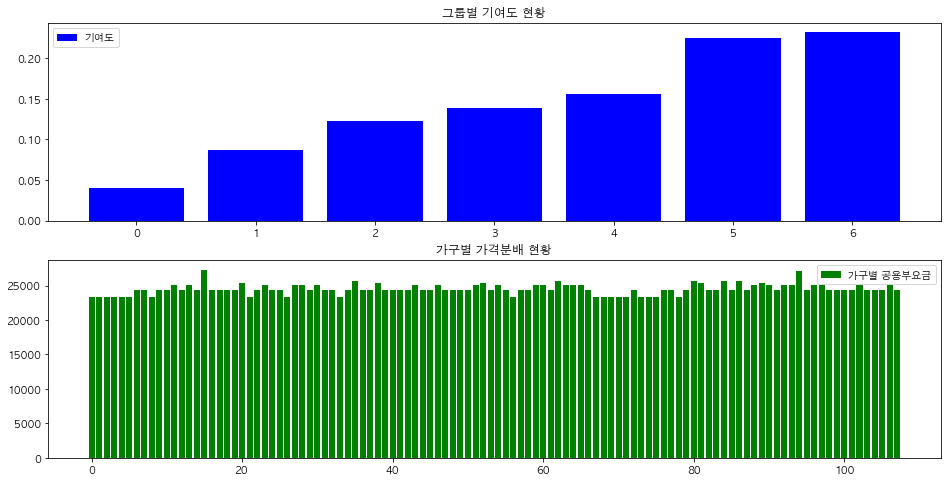

In [72]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1)), dist_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(dist_info_1)), dist_info_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [73]:
min_h = dist_info_1[dist_info_1['name'] == '아파트1-104-905']
mean_h = dist_info_1[dist_info_1['name'] == '아파트1-102-801']
max_h = dist_info_1[dist_info_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,0,836,22491,23327
44,아파트1-102-801,280,1,1809,22491,24300
15,아파트1-102-903,711,6,4834,22491,27325


## 기여도 적용비율 요금

In [74]:
norm_dist = cont_1.copy()

norm_dist['contribution'] = (norm_dist['contribution'] - norm_dist['contribution'].min()) / \
                    (norm_dist['contribution'].max() - norm_dist['contribution'].min())

norm_dist = pd.concat([norm_dist, col_df[col_df.columns[-2:]]], axis=1)

norm_dist['기여도 공용부 기본요금'] = (norm_dist['공용부 기본요금'] * norm_dist['contribution']).round().astype("int")
norm_dist['기여도 공용부 전력량요금'] = (norm_dist['공용부 전력량요금'] * norm_dist['contribution']).round().astype("int")
norm_dist['기여도 공용부 요금'] = norm_dist['기여도 공용부 기본요금'] + norm_dist['기여도 공용부 전력량요금']
norm_dist['가구 별 분배 가격'] = (norm_dist['기여도 공용부 요금'] / norm_dist['가구 수']).round().astype("int")

norm_dist

,클러스터 패턴 총 사용량,가구 수,contribution,공용부 기본요금,공용부 전력량요금,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배 가격
그룹 번호,,,,,,,,,
0,123,20,0.000000,85040,331880,0,0,0,0
1,266,53,0.243197,225356,879482,54806,213888,268694,5070
2,376,23,0.430272,97796,381662,42079,164219,206298,8969
3,424,5,0.511905,21260,82970,10883,42473,53356,10671
4,477,5,0.602041,21260,82970,12799,49951,62750,12550
5,689,1,0.962585,4252,16594,4093,15973,20066,20066
6,711,1,1.000000,4252,16594,4252,16594,20846,20846


In [75]:
norm_dist_info = cluster_info.copy()

norm_dist_info['단순 가격분배'] = norm_dist_info['그룹 번호'].map(
        lambda x: int(norm_dist.loc[x]['가구 별 분배 가격'])
)

norm_dist_info['공용부 요금 나머지'] = round((public_bill - norm_dist_info['단순 가격분배'].sum()) / len(norm_dist_info))
norm_dist_info['최종 공용부 요금'] = norm_dist_info['단순 가격분배'] + norm_dist_info['공용부 요금 나머지']

norm_dist_info.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-104-1206,99,0,0,18598,18598
1,아파트1-104-303,10,0,0,18598,18598
2,아파트1-104-1307,23,0,0,18598,18598
3,아파트1-104-1208,40,0,0,18598,18598
4,아파트1-104-408,39,0,0,18598,18598
5,아파트1-104-203,197,0,0,18598,18598
6,아파트1-103-1402,218,1,5070,18598,23668
7,아파트1-103-402,228,1,5070,18598,23668
8,아파트1-103-1201,84,0,0,18598,18598
9,아파트1-103-801,223,1,5070,18598,23668


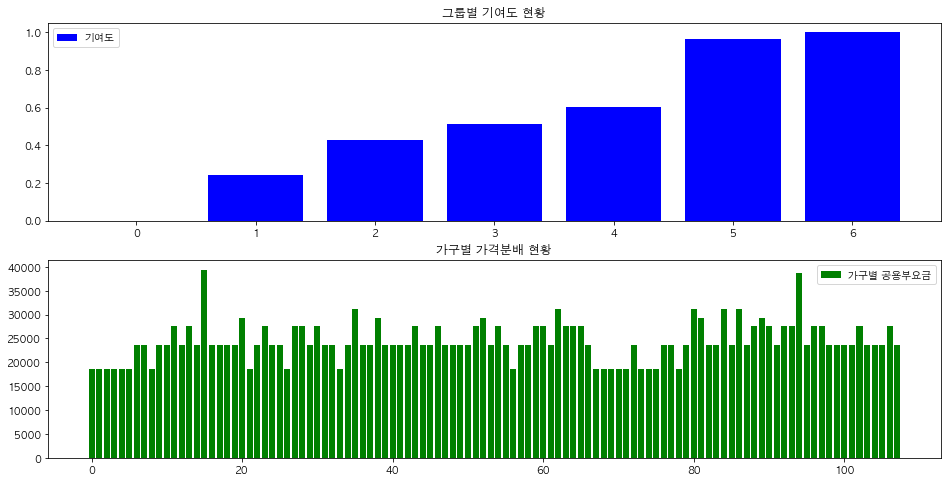

In [76]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1)), norm_dist['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(dist_info_1)), norm_dist_info['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [77]:
min_h = norm_dist_info[norm_dist_info['name'] == '아파트1-104-905']
mean_h = norm_dist_info[norm_dist_info['name'] == '아파트1-102-801']
max_h = norm_dist_info[norm_dist_info['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
69,아파트1-104-905,148,0,0,18598,18598
44,아파트1-102-801,280,1,5070,18598,23668
15,아파트1-102-903,711,6,20846,18598,39444


# histogram vs kmeans

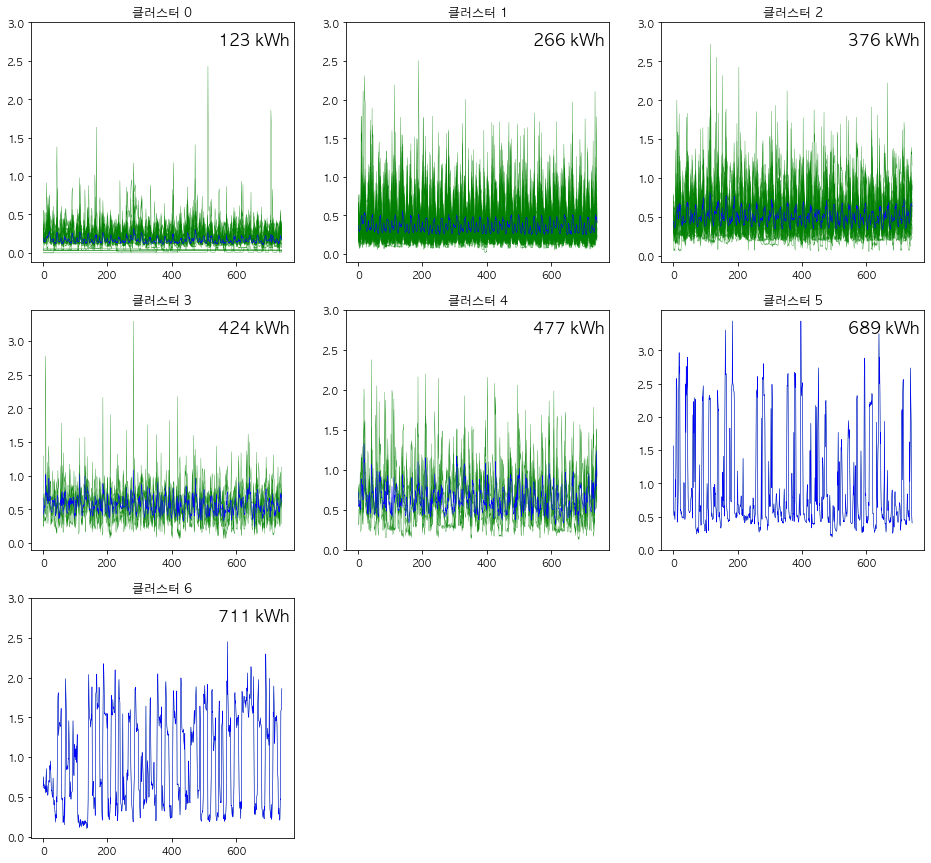

In [78]:
kmeans.draw_plot()

In [124]:
y, x = np.histogram(month_df['usage (kWh)'].values, bins=K)
hist_df = pd.DataFrame(columns=['start', 'end', '가구 수'])

for idx, _x in enumerate(x[:-1]):
    _y = y[idx]
    
    start = _x
    end = x[idx + 1]
    
    hist_df = hist_df.append({
        "start": start,
        "end": end,
        "가구 수": _y
    }, ignore_index=True)
    
groups = np.array([])

for usage in month_df['usage (kWh)']:
    chk = []
    
    for idx, row in hist_df.iterrows():
        start = row['start']
        end = row['end']
        
        chk.append((usage >= start) and (usage <= end))

    group_num = np.where(chk)[0][0]
    groups = np.append(groups, group_num).astype("int")
    
month_df['그룹 번호'] = groups
month_df.head(10)

,name,usage (kWh),그룹 번호
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
5,아파트1-104-203,197,1
6,아파트1-103-1402,218,2
7,아파트1-103-402,228,2
8,아파트1-103-1201,84,0
9,아파트1-103-801,223,2


In [125]:
hist_means = KMeans(datas=m_60_1.T.values)
hist_means.init_setting()

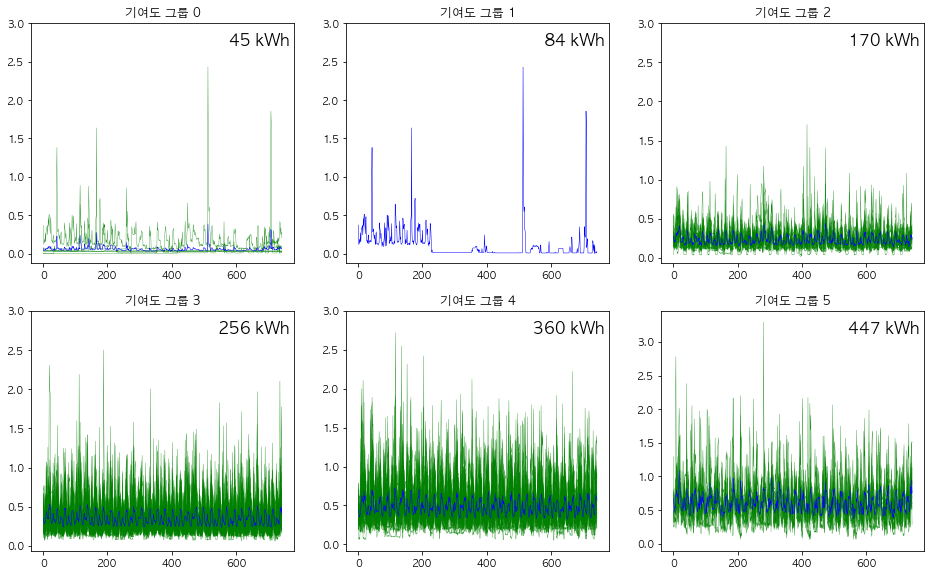

In [126]:
hist_means.labels_ = month_df['그룹 번호']
hist_means.next_setting()
# hist_means.next()
hist_means.sorting()
hist_means.draw_plot(name="기여도 그룹")

In [170]:
import datetime as dt

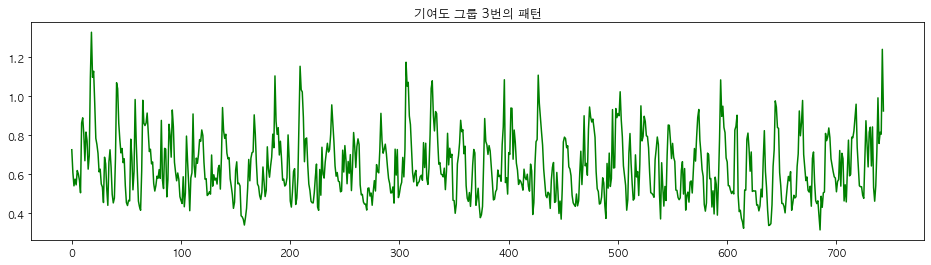

In [171]:
plt.figure(figsize=(16,4))

plt.plot(kmeans.clusters_[4], color='g')
plt.title("기여도 그룹 3번의 패턴")

plt.show()

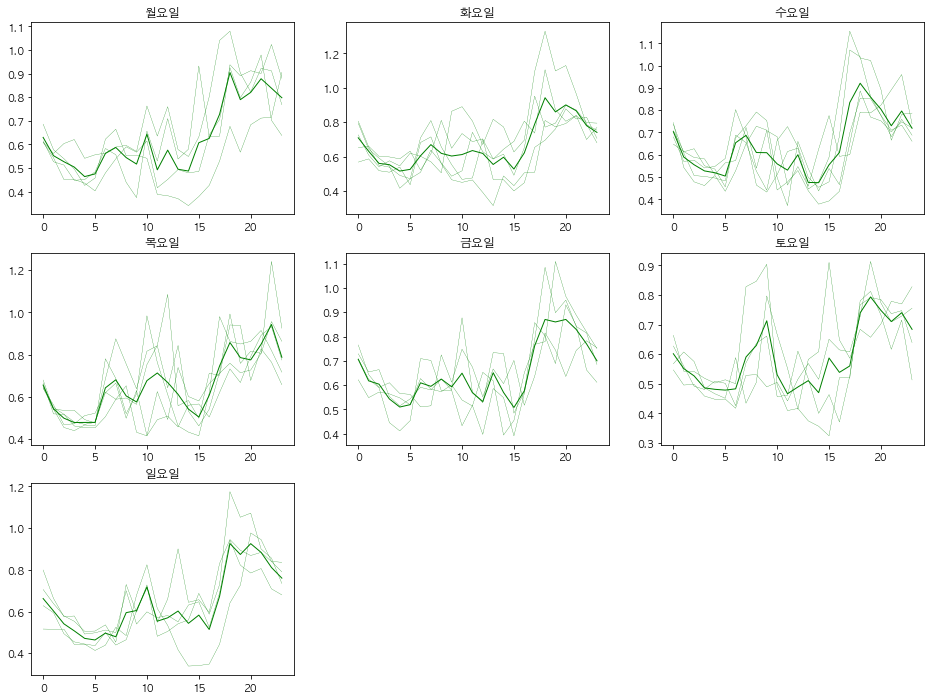

In [172]:
DAY_ARR = ['월', '화', '수', '목', '금', '토', '일']
plt.figure(figsize=(16, 12))

for weekday in range(0, 7):
    ax = plt.subplot(3,3,weekday+1)
    
    ax.plot(
        kmeans.clusters_[4][m_60_1.index.weekday == weekday].reshape(-1, 24).T,
        color='g', linewidth=0.25)
    ax.plot(
        kmeans.clusters_[4][m_60_1.index.weekday == weekday].reshape(-1, 24).mean(axis=0),
        color='g', linewidth=1)
    ax.set_title("{}요일".format(DAY_ARR[weekday]))
    
plt.show()

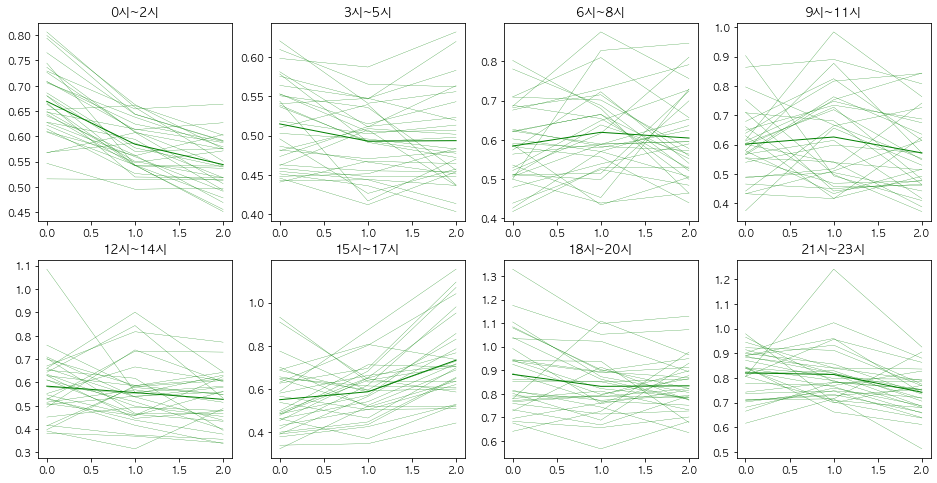

In [173]:
TIME_ARR = ['0시~2시', '3시~5시', '6시~8시', '9시~11시', '12시~14시', '15시~18시', '18시~20시', '21시~23시']
times = [(time, time+2) for time in range(0, 24, 3)]
plt.figure(figsize=(16, 8))

for idx,(start_time, end_time) in enumerate(times):
    ax = plt.subplot(2,4,idx+1)
    
    ax.plot(
        kmeans.clusters_[4][(m_60_1.index.time >= dt.time(start_time,0)) & 
                           (m_60_1.index.time <= dt.time(end_time,0))].reshape(-1, 3).T,
        color='g', linewidth=0.25)
    ax.plot(
        kmeans.clusters_[4][(m_60_1.index.time >= dt.time(start_time,0)) & 
                           (m_60_1.index.time <= dt.time(end_time,0))].reshape(-1, 3).mean(axis=0),
        color='g', linewidth=1)
    ax.set_title("{}시~{}시".format(start_time, end_time))
    
plt.show()